# Table of Contents

* [Loading data](#loading)
* [Cell of functions](#functions)
* [Prepare the Data for Machine Learning Algorithms](#start)
    * [Creating New Variables](#2.0)
    * [Stratified Undersampling](#1.1)
    * [Smoothed Target Encoding](#1.2)
    * [Training and Evaluating on the Training Set](#1.3)
* [Fine Tune The Model](#3)
* [Prepare the test set](#4)
* [Scoring & Evaluating](#5)
* [Conclusion](#Conclusion)
* [Sources](#Sources)

In [1]:
# Standard libraries
import pandas as pd
import numpy as np

# Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Processing and metrics 
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.utils import shuffle
import category_encoders as ce

# Saving model
import joblib

import warnings
warnings.filterwarnings("ignore")

# Loading the data <a class="anchor" id="loading"></a>

In [2]:
df = pd.read_csv('train.csv')

First of all, we retrieve __the same data sets as during the part 1__ (same `random_state=42`): 

In [3]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["event"]):
    train = df.loc[train_index]
    test = df.loc[test_index]

print("Train shape : {}".format(train.shape))
print("Test shape : {}".format(test.shape))

Train shape : (4082242, 19)
Test shape : (1020561, 19)


# Cell of functions <a class="anchor" id="functions"></a>

The following cell contains all functions I will use in this notebook to preprocess the data or evaluate models :

In [4]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df

def stratified_sample_report(df, strata, size=None):

    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd

def __smpl_size(population, size):

    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

def cross_validate_results(model, X_train, y_train) :
    
    scores = cross_validate(model, X_train, y_train, cv = 5, scoring = 'roc_auc',
                            n_jobs = -1, return_train_score = True)
    scores = pd.DataFrame(scores)
    results = scores.describe().transpose()
    
    return results

# Prepare the Data for Machine Learning Algorithms <a class="anchor" id="start"></a>

## Creating New Variables <a class="anchor" id="2.0"></a>

Here we create `creative_shape`, `date`, `from_friday_to_monday`, and `cpm_cat` features :

In [5]:
# creative_shape : 
train['creative_shape'] = train['creative_width'].astype(str) + " x " + train['creative_height'].astype(str)

# date & from_friday_to_monday:
train["date"] = pd.to_datetime(train[['year', 'month', 'day']])
train["from_friday_to_monday"] = np.where(train["date"] >= "2019-10-04", 1, 0)

# cpm_cat :
train["cpm_cat"] = pd.qcut(train["media_cost_dollars_cpm"], 4, labels=False)

## Stratified Undersampling <a class="anchor" id="1.1"></a>

To deal with the imbalanced dataset issue, I make the __assumption__ that __a lots of observations belonging to the majority class do not provide much more information,__ thus we can reduce this majority class to a smaller sample.  

But instead of randomly drop rows belonging to the majority class, we want __to create a representative sample of ads where users didn't click on__ (event = 0) __having the same size of the minority class__ (event = 1). The function `stratified_sample` allows us to create a stratified sample based on several columns selected wisely. 

We assume that `advertiser_id` and `cpm_cat` belongs to the more interesting candidate. Therefore, __our subsample will be representative in terms of these two variables :__

In [6]:
# Observations belonging to the majority class
train_0 = train[train['event'] == 0]

# Observations belonging to the minority class 
train_1 = train[train['event'] == 1]
size_minority_class = len(train_1)

# To get a quick view of our stratified sample
stratified_sample_report(train_0, ['advertiser_id','cpm_cat'], size_minority_class)

,advertiser_id,cpm_cat,size,samp_size
0,1872690,0,297358,229
1,1872690,1,522230,403
2,1872690,2,571561,441
3,1872690,3,541076,417
4,2040640,0,208732,161
5,2040640,1,80771,62
6,2040640,2,110629,85
7,2040640,3,78749,61
8,2078681,0,423467,327
9,2078681,1,318387,246


In [7]:
# To build our stratified sample of majority class : train_0_sample
train_0_sample = stratified_sample(train_0, ['advertiser_id','cpm_cat'],
                                   size=size_minority_class, seed=42, keep_index=False)

# Concatenate the stratified sample of impressions and the sample of clicks : new_train
new_train = pd.concat([train_0_sample, train_1], ignore_index=True)

# Shuffle rows 
new_train = shuffle(new_train)

# Display how our new train set is balanced
pd.DataFrame({"Count" : new_train["event"].value_counts(),
              "Proportion" : new_train["event"].value_counts(normalize=True).mul(100)})

,Count,Proportion
1,3146,50.0
0,3146,50.0


We split our `new_train` set into a `X_train` containing __the matrix of explanatory variables__, and `y_train` containing __the target variable__ :

In [8]:
not_col_4_train = ['creative_width','creative_height','year','month','day',
                   'new_auction_id_64','date','media_cost_dollars_cpm','event']

y_train = new_train["event"]
X_train = new_train[[f for f in new_train.columns if f not in not_col_4_train]]

## Smoothed Target Encoding <a class="anchor" id="1.2"></a>

Instead of dummy encoding of categorical variables and increasing the number of features, we can encode each level as the mean of the response. Let's take a example to better understand what is target mean encoding :   

<table>
<tr></tr>
<tr><td>

| Feature     | Target | MeanEncode |    
|:---:|:---:|:---:|
| A     | 1 | 0.75 |
| A     | 0 |  0.75 |
| A | 1  |  0.75 |
| A | 1 | 0.75 |
| B |  1  |  0.66 |
| B |   1 |  0.66 |
| B  | 0| 0.66 |
| C |  1|  1.00 |
| C | 1 |  1.00 |


</td><td>

Feature | MeanEncode |
:---:|:---:|
A | 0.75 (3 our of 4)|
B | 0.66 (2 our of 3 | 
C | 1.00 (2 out of 2)|
Overall |  0.77 (7 out of 9) |

</td></tr> </table>

For instance with the category A we get 0.75, which corresponds to __the probability of getting A knowing that the target is equal to 1__. 

In our use case, __target mean encoding amounts to replace each level of a categorical variable by its corresponding Click-Through-Rate (CTR).__

It seems to be a good approach but for rarest events (like event C in the example above) it is not really reliable, that's why we need a __paremeter of regularization__ : for rarest event, we will give more confidence (i.e. higher weight) to the overall click-through rate. The module `TargetEncoder` allow this kind of regularization with a parameter called `smoothing` : 

In [9]:
# Instantiate target mean encoding with smoothing = 100
target_encoding = ce.TargetEncoder(cols = X_train.columns, smoothing = 100)
# Fit to training set 
target_encoding.fit(X_train, y_train)
# Transform the training set
X_train_encoded = target_encoding.transform(X_train, y_train)
# Display the first 3 rows
X_train_encoded.head(3)

,fold_position,operating_system,browser,mobile_app_instance_id,advertiser_id,creative_id,carrier_id,device_id,geo_dma,new_publisher_id,new_site_domain,creative_shape,from_friday_to_monday,cpm_cat
3358,0.548451,0.469047,0.501042,0.500401,0.533792,0.743762,0.468002,0.525037,0.536181,0.600533,0.653276,0.856408,0.503756,0.682809
3211,0.548451,0.469047,0.501042,0.500401,0.533792,0.432512,0.507991,0.299161,0.487531,0.788443,0.800544,0.478393,0.503756,0.682809
5597,0.548451,0.577979,0.501042,0.500401,0.533792,0.586665,0.507991,0.753750,0.589375,0.482169,0.461867,0.425411,0.492841,0.682809


## Training and Evaluating on the Training Set <a class="anchor" id="1.3"></a>

Our training set is ready, we are now able to __train and evaluate several models using cross-validation.__ The function `cross_validate_results` performs 5-folds cross-validation by randomly splits the training set into 5 distinct subsets called *folds*, then it trains and evaluates the model 5 times, picking a different fold for evaluation every time and training on the other 4 folds. The result is a dataframe containing the mean train and evaluation ROC-AUC, allowing us to detect possible overfitting or underfitting. We try 3 different models : 
* LogisticRegression
* Random Forest
* Gradient Boosting

In [10]:
logistic_regression = LogisticRegression(random_state=42, C=1.0, solver="liblinear")
cross_validate_results(logistic_regression, X_train_encoded, y_train)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.057362,0.015131,0.040475,0.048566,0.058468,0.058471,0.080830
score_time,5.0,0.011299,0.006479,0.002025,0.010065,0.012106,0.012108,0.020191
test_score,5.0,0.860325,0.012692,0.850591,0.852891,0.857786,0.858058,0.882297
train_score,5.0,0.860965,0.002935,0.855986,0.861384,0.861468,0.862286,0.863702


In [11]:
random_forest = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=42)
cross_validate_results(random_forest, X_train_encoded, y_train)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,3.054059,0.215399,2.889518,2.960311,2.980506,3.008728,3.431231
score_time,5.0,0.173530,0.021879,0.161367,0.161375,0.161437,0.171614,0.211859
test_score,5.0,0.867610,0.013733,0.857068,0.861551,0.863002,0.864790,0.891639
train_score,5.0,0.929326,0.002136,0.926025,0.928480,0.929950,0.930964,0.931213


In [12]:
gradient_boosting = GradientBoostingClassifier(random_state=42, n_estimators=600, max_depth=2)
cross_validate_results(gradient_boosting, X_train_encoded, y_train)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,7.158436,0.626125,6.045371,7.356787,7.388221,7.465494,7.536309
score_time,5.0,0.030678,0.012675,0.015621,0.026713,0.029936,0.030453,0.050668
test_score,5.0,0.869055,0.013034,0.857381,0.863759,0.864271,0.868626,0.891240
train_score,5.0,0.906837,0.002831,0.901911,0.907471,0.907555,0.908126,0.909120


As Gradient Boosting seems to be slightly better than Random Forest and Logistic Regression (with a mean test AUC = 0.87), we choose this model and we now need to fine-tune it.

# Fine-Tune The Model <a class="anchor" id="3"></a>

We tune our model based on the two most important parameters in tree based model : __the number of trees__ and __their maximum depth.__ We fix the maximum number of features selected at each tree split equal to `sqrt(n_features)`

In [13]:
param_grid = {'n_estimators': [500,550,600,650,700], 'max_depth': [2,3,4]}

gradient_boosting = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(gradient_boosting,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True,
                           verbose=True)

grid_search.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  5.2min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [500, 550, 600, 650, 700]},
             return_train_score=True, scoring='roc_auc', verbose=True)

In [14]:
grid_search.best_params_

{'max_depth': 2, 'n_estimators': 500}

# Prepare the test set <a class="anchor" id="4"></a>

In [15]:
test['creative_shape'] = test['creative_width'].astype(str) + " x " + test['creative_height'].astype(str)
test["date"] = pd.to_datetime(test[['year', 'month', 'day']])
test["from_friday_to_monday"] = np.where(test["date"] >= "2019-10-04", 1, 0)

test.loc[test['media_cost_dollars_cpm'] < 0.158, 'cpm_cat'] = 0
test.loc[(test['media_cost_dollars_cpm'] >= 0.158) & (test['media_cost_dollars_cpm'] < 0.362), 'cpm_cat'] = 1
test.loc[(test['media_cost_dollars_cpm'] >= 0.362) & (test['media_cost_dollars_cpm'] < 0.854), 'cpm_cat'] = 2
test.loc[test['media_cost_dollars_cpm'] >= 0.854, 'cpm_cat'] = 3

test = test.drop(['creative_width','creative_height','year','month','day',
                  'new_auction_id_64','date','media_cost_dollars_cpm'], axis=1)

y_test = test["event"]
X_test = test.drop('event', axis=1)

X_test_encoded = target_encoding.transform(X_test)
X_test_encoded.head(3)

,fold_position,operating_system,browser,mobile_app_instance_id,advertiser_id,creative_id,carrier_id,device_id,geo_dma,new_publisher_id,new_site_domain,creative_shape,from_friday_to_monday,cpm_cat
3516489,0.162679,0.577979,0.501042,0.500401,0.447753,0.432969,0.501296,0.526416,0.471557,0.600533,0.653276,0.478393,0.503756,0.509057
4158612,0.548451,0.520982,0.501042,0.500401,0.533792,0.566366,0.507991,0.516268,0.526702,0.549099,0.527796,0.467898,0.492841,0.682809
3138651,0.548451,0.577979,0.501042,0.500401,0.447753,0.426425,0.507991,0.571742,0.492491,0.360688,0.286653,0.478393,0.503756,0.344714


# Scoring & Evaluating <a class="anchor" id="5"></a>

In [16]:
# Loading the model
final_model = grid_search.best_estimator_
# To predict 0 or 1 (click or impression)
y_pred = final_model.predict(X_test_encoded)
# To predict the probability that an ad is clicked
y_pred_proba = final_model.predict_proba(X_test_encoded)[:,1]

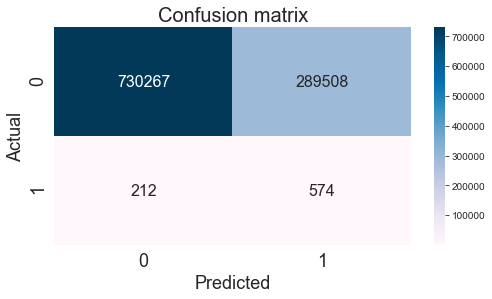

In [17]:
plt.figure(figsize = (8,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='2.0f', annot_kws={"size": 16}, cmap="PuBu")
plt.ylabel('Actual',fontsize=18) ; plt.xlabel('Predicted',fontsize=18)
plt.xticks(fontsize=18) ; plt.yticks(fontsize=18)
plt.title("Confusion matrix", fontsize=20)
plt.show()

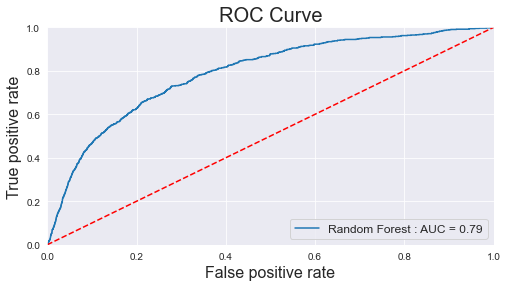

In [18]:
plt.figure(figsize=(8,4))
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC Curve', fontsize = 20)
plt.plot(fpr, tpr, label = 'Random Forest : AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 12)
plt.plot([0, 1], [0, 1],'r--') ; plt.xlim([0, 1]) ; plt.ylim([0, 1])
plt.ylabel('True positive rate', fontsize = 16) ; plt.xlabel('False positive rate', fontsize = 16)
plt.show()

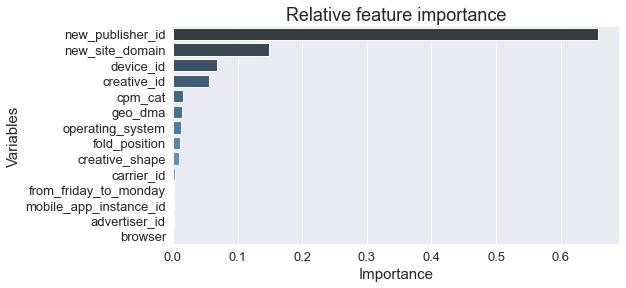

In [19]:
importances = final_model.feature_importances_
attributes = list(X_train_encoded)
a = sorted(zip(importances, attributes), reverse=True)
q = pd.DataFrame(a, columns = ["importances", "variables"])
fig, ax = plt.subplots(figsize = (8,4)) 
sns.barplot(x="importances", y="variables", data=q, palette="Blues_d")
plt.xticks(fontsize = 13), plt.yticks(fontsize=13)
plt.title("Relative feature importance", fontsize=18)
plt.ylabel('Variables',fontsize=15)
plt.xlabel("Importance",fontsize=15)
plt.show()

In [20]:
print(classification_report(y_test, y_pred))
print("Precision : {:.2%}".format(precision_score(y_test, y_pred)))
print("Recall : {:.2%}".format(recall_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       1.00      0.72      0.83   1019775
           1       0.00      0.73      0.00       786

    accuracy                           0.72   1020561
   macro avg       0.50      0.72      0.42   1020561
weighted avg       1.00      0.72      0.83   1020561

Precision : 0.20%
Recall : 73.03%


# Conclusion <a class="anchor" id="Conclusion"></a>

*  __In supervised machine learning, handle a highly imbalanced dataset is a real challenge :__ in this case, 73% of positive instances that are correctly detected by the classifier (recall = 73%), but the accuracy of the positive predictions is really poor (precision = 0.20%)
* The model __has trouble to detect underlying patterns related to the ads users click on__ 
* One possible way of improvement will be to __add more instances representing clicks, to get a balanced dataset__ with at least 30k observations (15k for each class)
* According to our tree based model, the 3 variables allowing the best differenciation between the 2 classes are `new_published_id`, `new_site_domain` and `device_id`
* Neural networks may be a good alternative to ensemble models, but the few number of positive instance may lead to the same issue
* The trade-off between the precision and the recall is highly present here : an increasing in the recall drastically reduce the precision

# Sources <a class="anchor" id="Sources"></a>

* Stratified sampling functions : https://www.kaggle.com/flaviobossolan/stratified-sampling-python
* Target Encoder : https://contrib.scikit-learn.org/category_encoders/targetencoder.html